In [ ]:
# !pip install -r 'requirements.txt' --quiet

In [13]:
import numpy as np

import torch
from torchvision.transforms import ToTensor
from torch import no_grad
from torchvision import datasets
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss, MaxPool2d, Flatten, Sequential, ReLU)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import qiskit
from qiskit import transpile, assemble, IBMQ
from qiskit.visualization import *
from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector
import qiskit.providers.fake_provider as fake
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer import AerSimulator, QasmSimulator

import matplotlib.pyplot as plt

In [14]:
provider = IBMQ.load_account()

configrc.store_credentials:WARNING:2022-07-14 13:45:59,648: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2022-07-14 13:46:00,481: Credentials are already in use. The existing account in the session will be replaced.


In [15]:
# device_backend = fake.FakeManila()
# backend = Aer.get_backend('aer_simulator_statevector')
# device = QasmSimulator.from_backend(device_backend)
# coupling_map = device.configuration().coupling_map
# noise_model = NoiseModel.from_backend(device)
# basis_gates = noise_model.basis_gates

# seed = 100
# algorithm_globals.random_seed = seed
# qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,
#                      coupling_map=coupling_map, noise_model=noise_model)

In [26]:
# Declare Quantum instance
noisy_backend = provider.get_backend('ibmq_manila')
backend_sim = AerSimulator.from_backend(noisy_backend)

qi = QuantumInstance(backend_sim)

print(backend_sim)

aer_simulator(ibmq_manila)


In [27]:
### Training and test data downloaded from FashionMNIST and transformed into tensors ###
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

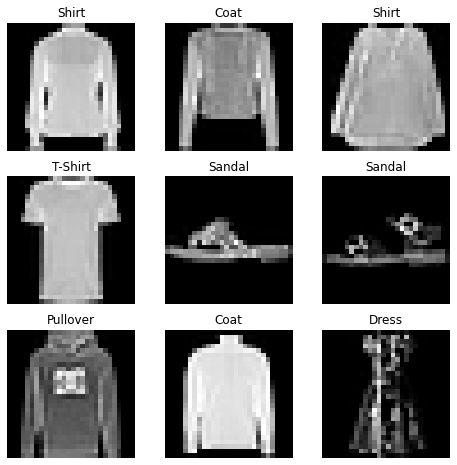

In [28]:
### Inspecting the images in the training data set with their labels ###
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [29]:
### Load training data into Torch DataLoader ###
X_train = training_data
n_samples = 500
batch_size = 64

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples],
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# A torch dataloader is defined with filtered data
train_loader = DataLoader(X_train, batch_size=64, shuffle=True)

In [30]:
# Load test data into Torch DataLoader
X_test = test_data

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(np.where(X_test.targets == 0)[0][:n_samples],
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=64, shuffle=True)

In [31]:
pi = np.pi
feature_dim = 2
reps = 2
duplicates = 1
feature_map_circuit = QuantumCircuit(feature_dim)
x = ParameterVector('x', feature_dim * reps)

for i in range(reps):
    for i in range(feature_dim):
        feature_map_circuit.h(i)

    feature_map_circuit.p(2*x[0], 0)
    feature_map_circuit.p(2*x[1], 1)
    feature_map_circuit.cnot(0, 1)
    feature_map_circuit.p(2*(pi - x[0])*(pi - x[1]), 1)
    feature_map_circuit.cnot(0, 1)

feature_map_circuit.draw()

┌───┐┌───────────┐                                        ┌───┐»
q_0: ┤ H ├┤ P(2*x[0]) ├──■──────────────────────────────────■──┤ H ├»
     ├───┤├───────────┤┌─┴─┐┌────────────────────────────┐┌─┴─┐├───┤»
q_1: ┤ H ├┤ P(2*x[1]) ├┤ X ├┤ P(2*(π - x[0])*(π - x[1])) ├┤ X ├┤ H ├»
     └───┘└───────────┘└───┘└────────────────────────────┘└───┘└───┘»
«     ┌───────────┐                                        
«q_0: ┤ P(2*x[0]) ├──■──────────────────────────────────■──
«     ├───────────┤┌─┴─┐┌────────────────────────────┐┌─┴─┐
«q_1: ┤ P(2*x[1]) ├┤ X ├┤ P(2*(π - x[0])*(π - x[1])) ├┤ X ├
«     └───────────┘└───┘└────────────────────────────┘└───┘

In [32]:
num_qubits = 2
ansatz_circuit = QuantumCircuit(num_qubits)
reps = 1
params = ParameterVector('θ', num_qubits + num_qubits * reps)
counter = 0

for i in range(num_qubits):
    ansatz_circuit.ry(params[counter], i)
    counter += 1

for j in range(reps):
    for k in range(num_qubits-1):
        ansatz_circuit.cnot(k, k+1)
    for m in range(num_qubits):
        ansatz_circuit.ry(params[counter], m)
        counter += 1

ansatz_circuit.draw()

┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘

In [33]:
### Two layer QNN constructed ###
feature_map_lib = ZZFeatureMap(feature_dimension=2, entanglement='linear')
ansatz_lib = RealAmplitudes(2, reps=1, entanglement='linear')
# print(feature_map_lib.decompose())
# print(ansatz_lib.decompose())
qnn2 = TwoLayerQNN(2, feature_map_lib, ansatz_lib, input_gradients=True,
                   exp_val=AerPauliExpectation(), quantum_instance=qi)
print(qnn2.operator)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  CircuitStateFn(
       ┌──────────────────────────┐┌──────────────────────────────────────┐
  q_0: ┤0                         ├┤0                                     ├
       │  ZZFeatureMap(x[0],x[1]) ││  RealAmplitudes(θ[0],θ[1],θ[2],θ[3]) │
  q_1: ┤1                         ├┤1                                     ├
       └──────────────────────────┘└──────────────────────────────────────┘
  )
])


In [34]:
### Torch NN module from Qiskit ###
class Net(Module):

    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)         # 2-dimensional input to QNN
        # Apply torch connector, weights chosen
        self.qnn = TorchConnector(qnn2)
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)
        # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return torch.cat((x, 1 - x), -1)

In [35]:
### Model trained and the loss computed ###
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))


Training [5%]	Loss: -0.6933
Training [10%]	Loss: -0.8374
Training [15%]	Loss: -0.8829
Training [20%]	Loss: -0.9190
Training [25%]	Loss: -0.9443
Training [30%]	Loss: -0.9708
Training [35%]	Loss: -1.0039
Training [40%]	Loss: -1.0222
Training [45%]	Loss: -1.0514
Training [50%]	Loss: -1.0776
Training [55%]	Loss: -1.1105
Training [60%]	Loss: -1.1268
Training [65%]	Loss: -1.1589
Training [70%]	Loss: -1.1783
Training [75%]	Loss: -1.2044
Training [80%]	Loss: -1.2286
Training [85%]	Loss: -1.2615
Training [90%]	Loss: -1.2790
Training [95%]	Loss: -1.3097
Training [100%]	Loss: -1.3232


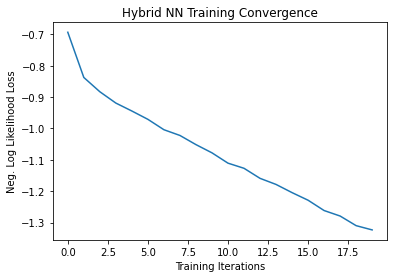

In [36]:
### Loss convergence plotted ###
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg. Log Likelihood Loss')
plt.show()

In [37]:
### Model evaluated ###
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        (correct / len(test_loader) / batch_size) * 100))


Performance on test data:
	Loss: -1.3218
	Accuracy: 92.3%


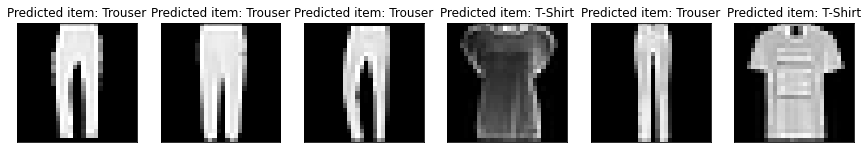

In [38]:
### Predicted images displayed. Either T-shirt or Trouser ###
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(15, 5))

model.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        if pred.item() == 0:
            axes[count].set_title('Predicted item: T-Shirt')  
        elif pred.item() == 1:
            axes[count].set_title('Predicted item: Trouser')  
        count += 1